In [27]:
import pandas as pd
import numpy as np
import feather
import re
pd.options.display.max_columns = None

# Load and Clean the Data

## Ticket Data for 2020 and 2021

- Load preprocessed files from feather

In [28]:
ticket20 = feather.read_dataframe('ticket_2020.feather')
# ticket19 = feather.read_dataframe('ticket_2019.feather')

### Peek at the Data

In [29]:
ticket20.sample(5)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
7581525,8714392574,T718903C,NY,OMT,01/07/2020 12:00:00 AM,21,SUBN,CADIL,T,34070,10610,10810,20201031,14.0,14,14,366461,T102,O,0851A,None,NY,F,264,W 15th St,None,0,408,E9,None,Y Y,0830A,1000A,BK,NaN,2016,None,0,99,None,NaN,NaN,NaN
1257933,8699098248,BEC2294,NY,PAS,07/29/2019 12:00:00 AM,20,SUBN,GMC,T,77730,6030,43230,20191130,76.0,76,76,362530,T302,Y,0204P,None,K,F,488,Smith St,None,0,408,C,None,YYYYYYY,None,None,WH,NaN,2014,None,0,C1,None,NaN,NaN,NaN
683723,8554451478,EGR3895,NY,PAS,07/15/2019 12:00:00 AM,38,4DSD,INFIN,T,9090,8440,8590,20200618,114.0,114,114,356949,T401,Q,1014A,None,Q,O,34-04,38th St,None,0,408,I4,None,YYYYYY,0900A,0700P,RD,NaN,2003,None,0,52-A,None,NaN,NaN,NaN
7811032,8796171248,39795MA,NY,COM,01/13/2020 12:00:00 AM,38,VAN,JEEP,T,10510,0,0,20210831,6.0,6,6,362626,T101,M,0341P,None,NY,I,E,6th Ave,45ft N/of W 9th St,0,408,I4,None,YYYYYY,1000A,0700P,GY,NaN,2014,None,0,95,None,NaN,NaN,NaN
5508384,8788206464,HXH2584,NY,PAS,11/07/2019 12:00:00 AM,40,4DSD,NISSA,T,35670,15710,11710,20200128,24.0,24,24,356262,T103,I,1011A,None,NY,F,141,W 95th St,None,0,408,I4,None,YYYYYYY,None,None,BL,NaN,2015,None,9,41,None,NaN,NaN,NaN


In [30]:
ticket20.shape

(12495734, 43)

In [31]:
# ticket19.sample(5)

In [32]:
# ticket19.shape

### Step 1 - Drop Missing/Blank Street Codes (for now)

Since we plan to use street codes to get a location of each ticket, we drop every ticket with no street code in Street Code1, Street Code2, Street Code3 (note: these represent ~30% of the 12mn rows - not an insignificant amount of data - potentially can group by Violation Location/Precinct perhaps?)

In [33]:
ticket20_clean=ticket20[(ticket20['Street Code1']!=0) | (ticket20['Street Code2']!=0) | (ticket20['Street Code3']!=0)].copy()

### Step 2 - Add Leading Zeros Back to Street Codes - ensure 5 digit

In [34]:
ticket20_clean['Street Code1'] = ticket20_clean['Street Code1'].apply('{0:0>5}'.format)
ticket20_clean['Street Code2'] = ticket20_clean['Street Code2'].apply('{0:0>5}'.format)
ticket20_clean['Street Code3'] = ticket20_clean['Street Code3'].apply('{0:0>5}'.format)

In [35]:
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN


In [36]:
ticket20_clean['Violation County'].unique()

array(['K', 'Q', 'BX', None, 'NY', 'R', 'BK', 'QN', 'MN', 'K   F', 'ST',
       'QUEEN', 'KINGS', 'QNS'], dtype=object)

### Step 3 - Map Violation County to Borough Code

Code Borough InTicket

- 1 Manhattan NY/MN
- 2 Bronx BX
- 3 Brooklyn K/BK/KINGS
- 4 Queens Q/QN/QUEEN/QNS
- 5 Staten Island R/ST
- 6 Nassau County
- 7 Westchester
- 8 New Jersey

Drop the 'K   F' - only one data point

In [37]:
# ticket20_clean[ticket20_clean['Violation County']=='K   F']
ticket20_clean.drop([94098],inplace=True)

In [38]:
ticket20_clean['Violation County'].unique()

array(['K', 'Q', 'BX', None, 'NY', 'R', 'BK', 'QN', 'MN', 'ST', 'QUEEN',
       'KINGS', 'QNS'], dtype=object)

In [39]:
boro_dict = {'NY':'1',
             'MN':'1',
             'BX':'2',
             'K':'3',
             'BK':'3',
             'KINGS':'3',
             'Q':'4',
             'QN':'4',
             'QUEEN':'4',
             'QNS':'4',
             'R':'5',
             'ST':'5',
             'None':'0'
            }

In [40]:
ticket20_clean['Boro Code'] = ticket20_clean['Violation County'].map(boro_dict)
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3


### Step 4 - Create lookup String to get Street Names

In [41]:
ticket20_clean['Street1LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code1']
ticket20_clean['Street2LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code2']
ticket20_clean['Street3LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code3']

In [42]:
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code,Street1LU,Street2LU,Street3LU
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF308730,PF305130,PF305280
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF386530,PF371800,PF373110
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF327030,PF341330,PF369230
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF333030,PF393630,PF358730
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3,PF345130,PF323930,PF368130


## Load Street Names DB and Create Lookup to StreetName Dict

In [43]:
stnames = pd.read_csv('/Users/stuartong/uberticketsyelp/Data/snd20d/snd20Dcow.txt')
stnames.columns=['Raw']

# from SND_metadata.pdf - location of stnames and Lookup prefixes
stnames['Street Name']=stnames['Raw'].str[2:34].str.strip()
stnames['Lookup']=stnames['Raw'].str[34:42]
stnames_dict= pd.Series(stnames['Street Name'].values,index=stnames['Lookup']).to_dict()

In [44]:
stnames

,Raw,Street Name,Lookup
0,11 0 BOND STREET PF1006890101...,0 BOND STREET,PF100689
1,11 1 AVENUE PF1100100101...,1 AVENUE,PF110010
2,11 1 AVENUE LOOP PF1317200102...,1 AVENUE LOOP,PF131720
3,11 1 AVENUE LOWER NB ROADBED VF1100100701...,1 AVENUE LOWER NB ROADBED,VF110010
4,11 1 AVENUE NORTHBOUND ROADBED VF1100100601...,1 AVENUE NORTHBOUND ROADBED,VF110010
...,...,...,...
106756,15ZENI PLACE VS5341050102...,ZENI PLACE,VS534105
106757,15ZEPHYR AVENUE PF5566960101...,ZEPHYR AVENUE,PF556696
106758,15ZEV PLACE PF5703670101...,ZEV PLACE,PF570367
106759,15ZOE STREET PF5567150101...,ZOE STREET,PF556715


In [45]:
stnames_dict

{'PF100689': '0 BOND STREET',
 'PF110010': '1 AVENUE',
 'PF131720': '1 AVENUE LOOP',
 'VF110010': 'VETERANS WAY',
 'PF101127': '1 AVENUE TUNNEL',
 'PF113655': '1 DRIVE',
 'VS112740': '1 PARK',
 'VS100058': 'PRECINCT    1 STATIONHOUSE',
 'PF110015': '1 PLACE',
 'PF100058': '1 PRECINCT STATIONHOUSE',
 'VS101232': 'FIRST ST GARDEN',
 '        ': 'TREMONT AVENUE WB ROADBED',
 'VS101346': 'ONE VANDERBILT',
 'VS111115': 'WSH',
 'PF110110': '2 AVENUE',
 'VF110110': 'YITZHAK RABIN WAY',
 'VS110780': 'SECOND AVENUE NB ENTRANCE HRD',
 'VF127310': 'WHITE PLAINS ROAD LINE',
 'VS132622': 'TWO BRIDGES URA SITE    7 HOUSE',
 'PF113470': '2 DRIVE',
 'PF110115': '2 PLACE',
 'VS120490': 'ROOSEVELT DRIVE SB ROADBED',
 'VF197710': '3 AVE BRDG PED AND BIKE PATH',
 'VS197510': 'WEST INTREPID MUSEUM PED OVPS',
 'VF197510': 'WEST 178-179 STREET PED OVERPASS',
 'PF110210': '3 AVENUE',
 'VS197850': 'THIRD AVENUE BRIDGE APPROACH',
 'VS197710': 'THIRD AVENUE BRIDGE BIKE PATH',
 'VS110785': 'THIRD AVENUE BRIDGE SB

### Step 5 - Get Street Names 

In [46]:
ticket20_clean['Street1'] = ticket20_clean['Street1LU'].map(stnames_dict)
ticket20_clean['Street2'] = ticket20_clean['Street2LU'].map(stnames_dict)
ticket20_clean['Street3'] = ticket20_clean['Street3LU'].map(stnames_dict)

In [202]:
ticket20_clean.head(10)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code,Street1LU,Street2LU,Street3LU,Street1,Street2,Street3
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF308730,PF305130,PF305280,43 STREET,2 AVENUE,3 AVENUE
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF386530,PF371800,PF373110,UNION STREET,PORTAL STREET,RALPH AVENUE
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF327030,PF341330,PF369230,CLERMONT AVENUE,FLUSHING AVENUE,PARK AVENUE
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF333030,PF393630,PF358730,DIVISION AVENUE,WILSON STREET,MARCY AVENUE
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3,PF345130,PF323930,PF368130,GRAND STREET,BUSHWICK AVENUE,OLIVE STREET
5,1440657920,KDG0693,PA,PAS,07/21/1990 12:00:00 AM,14,SUBN,HYUN,P,33440,62200,00000,20191231,100.0,100,100,963999,0100,0000,0525P,None,Q,None,None,B 99 ST,SHORE FRONT PKWY,0,408,C,None,BBBBBBB,ALL,ALL,GY,0.0,0,-,0,None,None,NaN,NaN,NaN,4,PF433440,PF462200,PF400000,BEACH 99 STREET,SHORE FRONT PARKWAY,NaN
7,1449130203,JJJ8186,NY,PAS,10/14/1990 12:00:00 AM,14,SUBN,BMW,P,10020,27480,27540,20210710,52.0,52,52,964971,0052,0000,0320A,None,BX,F,2734,BAINBRIDGE AVE,None,0,408,F2,None,BBBBBBB,ALL,ALL,BLK,0.0,2010,-,0,None,None,NaN,NaN,NaN,2,PF210020,PF227480,PF227540,BAINBRIDGE AVENUE,EAST 194 STREET,EAST 196 STREET
8,1451300189,DKD6024,NC,PAS,07/25/1991 12:00:00 AM,98,SDN,FORD,P,11280,54137,05430,20190930,68.0,68,68,945183,0068,0000,0843P,None,K,F,372,94 ST,None,0,408,C3,None,BBBBBBB,ALL,ALL,GREY,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF311280,PF354137,PF305430,94 STREET,LAFAYETTE WALK,4 AVENUE
9,1464768973,6542FR,99,PAS,01/01/2000 12:00:00 AM,40,SUBN,CMCKU,P,18070,25390,27790,0,17.0,17,405,930288,0405,0000,0739P,None,None,F,65,E 54 ST,None,0,408,C,None,BBBBBBB,ALL,ALL,RED,0.0,0,-,2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1449651100,JKZ9192,NY,PAS,01/02/2000 12:00:00 AM,74,SDN,HONDA,P,73470,48330,56230,20211014,73.0,73,73,0,0073,0000,1020A,None,None,None,985,ROCKAWAY AVE,None,0,408,F1,None,BBBBBBB,ALL,ALL,GREY,0.0,2019,-,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load Centerline Database

In [48]:
cl_df= pd.read_csv('/Users/stuartong/uberticketsyelp/Data/Centerline.csv')
cl_df.head()

,the_geom,L_LOW_HN,PHYSICALID,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng
0,MULTILINESTRING ((-73.87861544017795 40.861915...,NaN,164809,NaN,NaN,NaN,10458.0,10458.0,0,0,MITSUBISHI WILD WETLAND TRL,2,NaN,2,0,08/19/2014 12:00:00 AM +0000,12/22/2015 12:00:00 AM +0000,NV,6,13,13,NaN,NaN,NaN,NaN,TRL,NaN,NaN,MITSUBISHI WILD WETLAND TRL,MITSUBISHI WILD WETLAND,NaN,1026.077523
1,MULTILINESTRING ((-73.7729030190404 40.7778042...,215-001,6110,215-027,215-000,215-026,11360.0,11360.0,112261166,112262650,28 AVE,2,NaN,4,35,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,28 AVE,28,NaN,258.859740
2,MULTILINESTRING ((-73.90711253281893 40.905186...,5631,61140,5699,5602,5698,10471.0,10471.0,1522604870,1522601877,ARLINGTON AVE,2,NaN,2,42,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,H,NaN,NaN,NaN,AVE,NaN,NaN,ARLINGTON AVE,ARLINGTON,NaN,454.932922
3,MULTILINESTRING ((-73.98181677514282 40.687329...,317,145494,399,316,360,11217.0,11217.0,1922603730,1922612977,SCHERMERHORN ST,2,2.0,3,50,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,SCHERMERHORN ST,SCHERMERHORN,TW,609.424375
4,MULTILINESTRING ((-73.8300230194527 40.7140059...,120-011,12438,120-011,0,0,11415.0,11415.0,92261717,92269521,QUEENS BLVD,2,NaN,4,40,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,BLVD,NaN,NaN,QUEENS BLVD,QUEENS,NaN,47.399228


In [255]:
cl_df[(cl_df['FULL_STREE']=='GRAND ST')&(cl_df['BOROCODE']==3)]

,the_geom,L_LOW_HN,PHYSICALID,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng
3435,MULTILINESTRING ((-73.95164287939222 40.710906...,487,69872,499,490,500,11211.0,11211.0,1922602886,1922610545,GRAND ST,2,1.0,3,48,11/29/2007 12:00:00 AM +0000,04/14/2020 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,TW,147.309133
3854,MULTILINESTRING ((-73.94222776603294 40.711800...,773,69866,817,774,818,11211.0,11211.0,1922601751,1922602243,GRAND ST,2,1.0,3,52,11/29/2007 12:00:00 AM +0000,04/14/2020 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,TW,430.894424
4634,MULTILINESTRING ((-73.96128719656062 40.714502...,173,61721,217,172,218,11211.0,11211.0,1922603255,1922612490,GRAND ST,2,NaN,3,44,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,NaN,469.840610
5757,MULTILINESTRING ((-73.93480281865519 40.713372...,1005,69861,1049,1014,1078,11211.0,11211.0,1922602928,1922602472,GRAND ST,2,1.0,3,52,11/29/2007 12:00:00 AM +0000,04/14/2020 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,TW,476.228740
7299,MULTILINESTRING ((-73.92851149078601 40.714995...,1183,69877,1245,1200,1246,11211.0,11211.0,1922601558,1922607829,GRAND ST,2,NaN,3,40,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,NaN,463.777000
19215,MULTILINESTRING ((-73.95430286588835 40.711840...,401,69874,439,402,440,11211.0,11211.0,1922603381,1922613057,GRAND ST,2,NaN,3,32,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,NaN,360.039867
27186,MULTILINESTRING ((-73.94391095719863 40.711641...,725,69867,771,726,772,11211.0,11211.0,1922613299,1922605074,GRAND ST,2,1.0,3,48,11/29/2007 12:00:00 AM +0000,04/14/2020 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,TW,470.223326
32104,MULTILINESTRING ((-73.96277758654267 40.715106...,127,61720,171,128,170,11249.0,11249.0,1922602940,1922613397,GRAND ST,2,NaN,3,44,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,NaN,468.170694
39590,MULTILINESTRING ((-73.94724443883226 40.711324...,623,69869,669,624,670,11211.0,11211.0,1922606707,1922608741,GRAND ST,2,1.0,3,48,11/29/2007 12:00:00 AM +0000,04/14/2020 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,TW,460.501301
40966,MULTILINESTRING ((-73.9323301595279 40.7140099...,0,167947,0,1102,1108,11211.0,11211.0,1922614731,1922602472,GRAND ST,2,2.0,3,58,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,GRAND ST,GRAND,TW,247.321680


In [49]:
cl_gjson=pd.read_json('/Users/stuartong/uberticketsyelp/Data/NYC Street Centerline (CSCL).geojson')

In [256]:
cl_gjson['street']=cl_gjson['features'].str['properties'].str['full_stree']
cl_gjson['borocode']=cl_gjson['features'].str['properties'].str['borocode']
cl_gjson['roadtype']=cl_gjson['features'].str['properties'].str['rw_type']
cl_gjson['lowadd']=cl_gjson['features'].str['properties'].str['l_low_hn']
cl_gjson['coords']=cl_gjson['features'].str['geometry'].str['coordinates']

In [257]:
cl_gjson[(cl_gjson['street'].str.contains('BROADWAY'))&(cl_gjson['borocode']=='1')]

,type,features,street,borocode,roadtype,coords,lowadd
229,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.97073269636819, 40.79591917001086], [-7...",0
579,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.98246970821263, 40.76403346366594], [-7...",1709
611,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.94269535680036, 40.837221854142214], [-...",3879
746,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.96380137096992, 40.80796160874475], [-7...",0
768,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY ALY,1,1,"[[[-73.98228834763424, 40.7409554027091], [-73...",2
...,...,...,...,...,...,...,...
118725,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",W BROADWAY,1,1,"[[[-74.00968975296283, 40.71495099314357], [-7...",78
118868,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.95175395615833, 40.82447025697705], [-7...",0
118930,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.93419319586869, 40.853200394659034], [-...",4353
119250,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.94360977515329, 40.83597199616645], [-7...",3841


In [201]:
cl_gjson[(cl_gjson['street']=='BROADWAY')&(cl_gjson['borocode']=='1')&(cl_gjson['roadtype']=='1')]

,type,features,street,borocode,roadtype,coords
229,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.97073269636819, 40.79591917001086], [-7..."
579,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.98246970821263, 40.76403346366594], [-7..."
611,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.94269535680036, 40.837221854142214], [-..."
746,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.96380137096992, 40.80796160874475], [-7..."
2392,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.92889072625469, 40.864662994881165], [-..."
...,...,...,...,...,...,...
118659,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.9583949667519, 40.81579688632945], [-73..."
118868,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.95175395615833, 40.82447025697705], [-7..."
118930,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.93419319586869, 40.853200394659034], [-..."
119250,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",BROADWAY,1,1,"[[[-73.94360977515329, 40.83597199616645], [-7..."


In [ ]:
GRAND STREET	BUSHWICK AVENUE	OLIVE STREET

In [267]:
ave3 = []
for i in cl_gjson[(cl_gjson['street']=='GRAND ST')&(cl_gjson['borocode']=='3')&(cl_gjson['roadtype']=='1')]['coords']:
    print (i[0])
    ave3.append(i[0][0])
    
e17st = []
for i in cl_gjson[(cl_gjson['street']=='BUSHWICK AVE')&(cl_gjson['borocode']=='3')]['coords']:
    print (i[0])
    e17st.append(i[0][0])
    
e18st = []
for i in cl_gjson[(cl_gjson['street']=='OLIVE ST')&(cl_gjson['borocode']=='3')]['coords']:
    print (i[0])
    e18st.append(i[0][0])

[[-73.95164287939222, 40.710906314325925], [-73.95111565749674, 40.71095661947493]]
[[-73.94222776603294, 40.711800639363844], [-73.94068803134424, 40.711962047631616]]
[[-73.96128719656062, 40.71450229696462], [-73.95979763206105, 40.713887133734545]]
[[-73.93480281865519, 40.713372495593696], [-73.93317899912154, 40.71379901901624]]
[[-73.92851149078601, 40.71499547920741], [-73.92692555770466, 40.71540072178322]]
[[-73.95430286588835, 40.7118402404937], [-73.95312758030762, 40.711419787450566]]
[[-73.94391095719863, 40.711641487153976], [-73.94222776603294, 40.711800639363844]]
[[-73.96277758654267, 40.715106634804386], [-73.96128719656062, 40.71450229696462]]
[[-73.94724443883226, 40.71132447140526], [-73.9455962474616, 40.71148150066268]]
[[-73.9323301595279, 40.71400996318601], [-73.93148254530696, 40.714221748337366]]
[[-73.95680951657143, 40.712756388272865], [-73.955475961298, 40.71226542569624]]
[[-73.95979763206105, 40.713887133734545], [-73.95834207509, 40.71330630064778]]


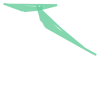

In [268]:
mls=MultiLineString([
   ave3,e17st,e18st
])

mls

In [269]:
line1=MultiLineString([ave3])
line2=MultiLineString([e17st])
line3=MultiLineString([e18st])
mylines = [line1,line2,line3]

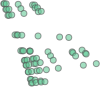

In [270]:
res1=line1.intersection(line2)
res1

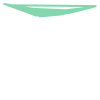

In [271]:
line1

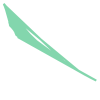

In [272]:
line2

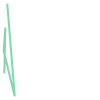

In [273]:
line3

In [117]:
full_coords

[[[-73.96110997058013, 40.76906440780265],
  [-73.9606018063753, 40.76974918670643]],
 [[-73.9381445755196, 40.800509732485516],
  [-73.93768600458877, 40.801140916011825]],
 [[-73.94839517770095, 40.786460184511554],
  [-73.94833227536796, 40.78654843022579],
  [-73.94829274007103, 40.78660389450197],
  [-73.94825639196125, 40.786654886936816],
  [-73.94792440877127, 40.78712062502046]],
 [[-73.9647554491405, 40.7640570700971],
  [-73.96429790392955, 40.764681987117925]],
 [[-73.9707591941885, 40.75582485073992],
  [-73.97031393611448, 40.7564530190295]],
 [[-73.97493471259061, 40.750099627607256],
  [-73.97444451625712, 40.75076469249241]],
 [[-73.97860713336334, 40.745057830107015],
  [-73.97812378207455, 40.745727173247516]],
 [[-73.98450757539061, 40.73696248670863],
  [-73.98437406003536, 40.737145456933],
  [-73.98408212938702, 40.737545516247366]],
 [[-73.95494520074165, 40.77750394666422],
  [-73.95448224181145, 40.77813866401679]],
 [[-73.98493339345687, 40.73637638484095],
 

In [98]:
test_list

[(-73.87861544017795, 40.86191530153914),
 (-73.8786122906838, 40.861905665471),
 (-73.87860961001435, 40.86189594747457),
 (-73.8786074016745, 40.861886161457974),
 (-73.87860566917195, 40.86187631982168),
 (-73.87860441468642, 40.861866437142524),
 (-73.87860363951931, 40.86185652565106),
 (-73.87860334518933, 40.861846599420886),
 (-73.87860353255412, 40.86183667202225),
 (-73.87860420004561, 40.86182675618532),
 (-73.87860634362991, 40.86181181620364),
 (-73.87860791909888, 40.861796835083545),
 (-73.87860892466473, 40.86178182538742),
 (-73.87860935986241, 40.86176680034911),
 (-73.8786092240086, 40.86175177186207),
 (-73.87860851663821, 40.86173675316013),
 (-73.87860723971737, 40.86172175530189),
 (-73.87860539300073, 40.861706792024),
 (-73.87860297911358, 40.861691875893406),
 (-73.87859999913972, 40.86167701780025),
 (-73.87859645636273, 40.86166223232246),
 (-73.87859235319092, 40.86164753001648),
 (-73.87858769313219, 40.86163292345018),
 (-73.87858247969412, 40.86161842535

In [92]:
cl_df[cl_df['ST_LABEL']=='84 ST']

,the_geom,L_LOW_HN,PHYSICALID,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng
703,MULTILINESTRING ((-73.87768978102245 40.729435...,0,12559,0,58-000,58-012,11379.0,11379.0,92270401,92267887,84 ST,2,NaN,4,26,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,FT,1,13,13,H,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,80.535592
1480,MULTILINESTRING ((-73.85225824202813 40.674057...,NaN,30646,NaN,NaN,NaN,11417.0,11417.0,0,0,84 ST,2,NaN,4,60,11/29/2007 12:00:00 AM +0000,01/08/2020 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,27.086808
3545,MULTILINESTRING ((-73.883184052253 40.75396674...,NaN,31841,NaN,NaN,NaN,11372.0,11372.0,0,0,84 ST,2,NaN,4,42,11/29/2007 12:00:00 AM +0000,11/13/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,32.604707
4977,MULTILINESTRING ((-73.99261918572854 40.603090...,2201,93717,2299,2200,2298,11214.0,11214.0,1822601912,1822601997,84 ST,2,NaN,3,28,11/29/2007 12:00:00 AM +0000,01/03/2019 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,789.867057
7134,MULTILINESTRING ((-74.03310842055332 40.625647...,201,37350,299,200,298,11209.0,11209.0,1822602628,1822607458,84 ST,2,NaN,3,30,11/29/2007 12:00:00 AM +0000,01/03/2019 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,779.618934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118562,MULTILINESTRING ((-73.8524657857291 40.6755842...,132-001,30644,132-007,109-000,131-098,11417.0,11417.0,52260818,52261955,84 ST,2,NaN,4,40,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,108.506566
118588,MULTILINESTRING ((-73.8528511222164 40.6775635...,107-001,30639,107-099,107-000,107-098,11417.0,11417.0,52262245,52261955,84 ST,2,NaN,4,35,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,238.181165
118841,MULTILINESTRING ((-73.84909548225262 40.661315...,157-001,29140,157-099,157-000,157-098,11414.0,11414.0,42261542,42262420,84 ST,2,NaN,4,50,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,619.582076
119162,MULTILINESTRING ((-74.00130866077215 40.608343...,1801,93716,1899,1800,1898,11214.0,11214.0,1822609613,1822606130,84 ST,2,NaN,3,30,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,84 ST,84,NaN,730.623363


In [50]:


cl_gjson.loc[0]['features']

{'type': 'Feature',
 'properties': {'rw_type': '6',
  'l_low_hn': None,
  'pre_direct': None,
  'st_width': '0',
  'r_zip': '10458',
  'r_low_hn': None,
  'bike_lane': None,
  'post_type': 'TRL',
  'r_blkfc_id': '0',
  'bike_trafd': None,
  'frm_lvl_co': '13',
  'post_modif': None,
  'pre_type': None,
  'full_stree': 'MITSUBISHI WILD WETLAND TRL',
  'l_blkfc_id': '0',
  'shape_leng': '1026.07752317',
  'to_lvl_co': '13',
  'modified': '2015-12-22T00:00:00.000Z',
  'status': '2',
  'post_direc': None,
  'r_high_hn': None,
  'l_zip': '10458',
  'snow_pri': None,
  'borocode': '2',
  'trafdir': 'NV',
  'pre_modifi': None,
  'st_label': 'MITSUBISHI WILD WETLAND TRL',
  'physicalid': '164809',
  'st_name': 'MITSUBISHI WILD WETLAND',
  'created': '2014-08-19T00:00:00.000Z',
  'l_high_hn': None},
 'geometry': {'type': 'MultiLineString',
  'coordinates': [[[-73.87861544017795, 40.86191530153914],
    [-73.8786122906838, 40.861905665471],
    [-73.87860961001435, 40.86189594747457],
    [-73.87

In [52]:
import psycopg2

connection = psycopg2.connect(database='nyc_gis',user='stuart',password='stuart')
cursor = connection.cursor()
cursor.execute("CREATE TABLE street_data (id SERIAL PRIMARY KEY,stname VARCHAR(255),borocode INT, roadtype INT,shape GEOMETRY)")

In [53]:
connection.commit()

In [93]:
from shapely.geometry import MultiLineString
from shapely import geometry, ops

test=cl_gjson.loc[0]['features']['geometry']['coordinates']
test_list=[]
for i in test[0]:
    coord = (i[0],i[1])
    test_list.append(coord)
    
test_list

test2=cl_gjson.loc[2]['features']['geometry']['coordinates']
test_list2=[]
for i in test2[0]:
    coord = (i[0],i[1])
    test_list2.append(coord)
    
test_list2

[(-73.90711253281893, 40.90518625079211),
 (-73.90672345950594, 40.90639950030468)]

In [94]:


mls=MultiLineString([
   test_list,test_list2
])


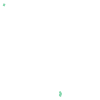

In [95]:
mls

In [221]:
cl_gjson[cl_gjson['street']=='STERLING PL']

,type,features,street,borocode,roadtype,coords
11088,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.92532872177273, 40.67116871653139], [-7..."
21573,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.96751874811476, 40.67549258275206], [-7..."
22443,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.96039301868899, 40.673998602434864], [-..."
25243,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.96949738850478, 40.675906379964424], [-..."
28020,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.91710818222478, 40.67072213170123], [-7..."
31736,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.97867669872811, 40.67904704646691], [-7..."
33081,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.91702174468996, 40.670717413788815], [-..."
34281,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.93917604732064, 40.67192600048198], [-7..."
37579,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.94748050653878, 40.672379646634575], [-..."
37797,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",STERLING PL,3,1,"[[[-73.940846629124, 40.67201614883133], [-73...."


In [230]:
from shapely.geometry import MultiLineString
from itertools import combinations

multiline=cl_gjson[cl_gjson['street']=='STERLING PL']['coords']
multiline

11088     [[[-73.92532872177273, 40.67116871653139], [-7...
21573     [[[-73.96751874811476, 40.67549258275206], [-7...
22443     [[[-73.96039301868899, 40.673998602434864], [-...
25243     [[[-73.96949738850478, 40.675906379964424], [-...
28020     [[[-73.91710818222478, 40.67072213170123], [-7...
31736     [[[-73.97867669872811, 40.67904704646691], [-7...
33081     [[[-73.91702174468996, 40.670717413788815], [-...
34281     [[[-73.93917604732064, 40.67192600048198], [-7...
37579     [[[-73.94748050653878, 40.672379646634575], [-...
37797     [[[-73.940846629124, 40.67201614883133], [-73....
40306     [[[-73.97188596838825, 40.67639465297692], [-7...
46935     [[[-73.9543164713996, 40.67275343223], [-73.95...
47367     [[[-73.93363490519087, 40.67162643364112], [-7...
48991     [[[-73.94194505140898, 40.672077330988756], [-...
50671     [[[-73.93640533019064, 40.671774305514745], [-...
52921     [[[-73.95702039611027, 40.67329390047459], [-7...
53631     [[[-73.97618051352337, 40.6780

In [211]:
for line1, line2 in combinations([line for line in multiline],2):
    if line1.intersects(line2):
        print(line1.intersection(line2))

AttributeError: 'list' object has no attribute 'intersects'

In [175]:
test=cl_df[(cl_df['FULL_STREE'].str.contains('63 ST')) & (cl_df['BOROCODE']==1) & (cl_df['RW_TYPE']==1)]['the_geom'].values.tolist()

In [176]:
test

['MULTILINESTRING ((-73.94224145731903 40.8378434363573, -73.9430091189847 40.838167191816105, -73.94324855801871 40.83826867971469, -73.94373631643596 40.838469720598646))',
 'MULTILINESTRING ((-73.96251524054111 40.763112733624226, -73.96155703699257 40.762708370255645))',
 'MULTILINESTRING ((-73.95914883433508 40.761698733149856, -73.9583419202339 40.76136331545021))',
 'MULTILINESTRING ((-73.9647554491405 40.7640570700971, -73.96251524054111 40.763112733624226))',
 'MULTILINESTRING ((-73.95733230614904 40.76100332691441, -73.95704972900496 40.76089447250021, -73.95688540628484 40.760826085028114))',
 'MULTILINESTRING ((-73.97118520979612 40.76677028966978, -73.96958441466369 40.76609086532323))',
 'MULTILINESTRING ((-73.94010227609465 40.83694508452738, -73.94204096173274 40.83776058068131))',
 'MULTILINESTRING ((-73.98011181561736 40.770528368678384, -73.98204042141927 40.77134357833112))',
 'MULTILINESTRING ((-73.95790133695364 40.76118089671778, -73.95779088519572 40.76117998567

In [38]:
cl_df[(cl_df['FULL_STREE'].str.contains('2 AVE')) & (cl_df['BOROCODE']==1) & (cl_df['RW_TYPE']==1)]['the_geom'].values.tolist()

['MULTILINESTRING ((-73.98942914226258 40.726187462929246, -73.98898482054337 40.72677887514424))',
 'MULTILINESTRING ((-73.97126234449263 40.75112224029439, -73.97080361265334 40.75174820121419))',
 'MULTILINESTRING ((-73.98590859659755 40.73101907998302, -73.98575300286302 40.731232945334646, -73.98544389943555 40.731657806760126))',
 'MULTILINESTRING ((-73.98767161543276 40.728595104268415, -73.9872497770919 40.72918616120114))',
 'MULTILINESTRING ((-73.96988589832242 40.75299884867012, -73.96943102550703 40.753623508485795))',
 'MULTILINESTRING ((-73.97636377328153 40.74409868112593, -73.97588117681829 40.74477922428447))',
 'MULTILINESTRING ((-73.96760620834938 40.75613198849283, -73.96715254341488 40.75676519476172))',
 'MULTILINESTRING ((-73.95836533252375 40.768797733573905, -73.95786679270606 40.76948404767775))',
 'MULTILINESTRING ((-73.98311380691291 40.73483804730168, -73.98270105748783 40.73543184572241))',
 'MULTILINESTRING ((-73.9324129069313 40.80441537406221, -73.93218